In [158]:
import time

import gym
from scipy import stats, special
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import models
from experiment import Seedable, SingleScenarioMetrics, plot_cum_regret

In [2]:
%load_ext autoreload
%autoreload 2

# Contextual bandit OpenAI Gym Environment Implementation

In [4]:
env = gym.make('CartPole-v0')
obs = env.reset()

for t in range(1000):
    env.render()
    random_action = env.action_space.sample()
    obs, reward, done, info = env.step(random_action)
    if done:
        print(f"Episode finished after {t} timesteps")
        break

env.close()

Episode finished after 48 timesteps


In [5]:
env.action_space

Discrete(2)

In [6]:
env.observation_space

Box(4,)

In [7]:
env.observation_space.high

array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)

In [8]:
env.observation_space.low

array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32)

In [176]:
list(gym.envs.registry.all())[::100]

[EnvSpec(Copy-v0),
 EnvSpec(AirRaidDeterministic-v4),
 EnvSpec(BattleZone-ram-v4),
 EnvSpec(ChopperCommand-ramNoFrameskip-v4),
 EnvSpec(FrostbiteDeterministic-v4),
 EnvSpec(Krull-ram-v4),
 EnvSpec(Pooyan-ramNoFrameskip-v4),
 EnvSpec(SpaceInvadersDeterministic-v4),
 EnvSpec(WizardOfWor-ram-v4)]

In [10]:
spec = gym.envs.registry.spec('Hopper-v2')
{name: getattr(spec, name) for name in dir(spec)
 if not name.startswith('_')}

{'id': 'Hopper-v2',
 'make': <bound method EnvSpec.make of EnvSpec(Hopper-v2)>,
 'max_episode_seconds': None,
 'max_episode_steps': 1000,
 'nondeterministic': False,
 'reward_threshold': 3800.0,
 'tags': {'wrapper_config.TimeLimit.max_episode_steps': 1000},
 'timestep_limit': 1000,
 'trials': 100}

## Creating a new environment

I've pieced together the following from reading the `openai/gym` source code.

1.  A new environment can be registered by calling `gym.register(name, **kwargs)`
    1.  The name is a unique identifier string for the environment
    2.  The kwargs include a set of metadata. Some of this is optional. The important stuff seems to be:
        1.  `entry_point`: Environment class or full qualified path to the class (which will be loaded dynamically)
        2.  `trials`: number of trials to average reward over
        3.  `kwargs`: passed through to Environment class
        4.  `max_episode_steps`: specify max number of time steps per replication / trial. If you do this, you don't need to manage this in the lower-level environment. It will be wrapped in a `gym.wrappers.TimeLimit` which will set the `done` attribute to True when `step` has been called `max_episode_steps` times.
2.  Once registered, a new instance can be created by calling `gym.make(name)`
    1.  This will create a new Environment instance by passing in `**kwargs` to `entry_point
3.  Every `Environment` needs:
    1.  to implement 5 methods:
        1.  `reset()`: reset state of environment, and return initial observation
        2.  `step(action)`: run one timestep, return tuple of `(observation, reward, done, info)`
        3.  `seed(seed=None)`: set seed for env's RNG
        4.  `close()`: perform any necessary cleanup operations
        5.  `render(mode='human')`: render env if supported. This is not required, but it may be useful to implement something later on.
    2.  to set 2-3 attributes:
        1.  `action_space`: Space object representing valid actions
        2.  `observation_space`: Space object representing valid observations
        3.  (optional) `reward_range`: tuple specifying (min, max) of possible rewards, e.g. (0, 1) for binary

### ContextualBanditEnvironment

Each of our environments will be fully-characterized by:

1.  Number of arms
2.  Number of time steps
3.  Context-generating distribution for decision instances (i.e. population characteristics)
    -   which naturally encodes the number of context variables & covariates
4.  True effects for each context covariate for each arm (assumed linear)
5.  Random seed

The link function will be Binomial-logistic for all our simulations for now. So rewards will be binary.

The action space will be `range(num_arms)`.

The observation space will correspond to the context-generating distribution.

#### First environment

For the first environment, we'll have:

1. 10 real-valued context variables, with no interactions
2. Homogeneous effect sizes (all same variance)
3. 10 arms
4. 100 time steps

We'll start with what I believe is the simplest scenario:

-   9 of the arms will have exactly the same effects.
-   1 will have slightly better effects, so it is best for every context.

Contexts will be generated to be strictly positive, to make the setting of "better" effects as simple as increasing any of them.

This is part of the `OneBest` class of scenarios.

-   One arm is the best across all contexts and the rest are the same.

This will also be a `SparseRewards` scenario

-   where most reward distributions yield rewards very seldom (less than 5% of the time)

In [22]:
num_arms = 10
num_time_steps = 100
num_predictors = 10
shared_variance = 0.5

rng = np.random.RandomState(42)

In [23]:
# context-generating distribution
dist = stats.truncnorm(0, 10, loc=0, scale=shared_variance)
context = dist.rvs(num_predictors, random_state=rng)
context

array([0.2440635 , 0.98305592, 0.55383303, 0.41961388, 0.09840172,
       0.09838631, 0.03643071, 0.74959595, 0.42180713, 0.5269514 ])

In [24]:
rng.seed(42)
effect_dist = stats.norm(-1, 0.5)
shared_effects = effect_dist.rvs(size=num_predictors, random_state=rng)
special.expit(shared_effects.dot(context))

0.03545851034183353

In [25]:
arm_effects = np.tile(shared_effects, 9).reshape(9, num_predictors)
np.all(arm_effects[0] == arm_effects[1])

True

In [26]:
better_effects = shared_effects.copy()
better_effects += stats.truncnorm.rvs(0.4, 0.7, loc=0.5, scale=0.1, size=num_predictors)
special.expit(better_effects.dot(context))

0.2628592904582224

In [27]:
all_effects = np.ndarray((10, 10))
all_effects[:-1] = arm_effects
all_effects[-1] = better_effects
rates = special.expit(all_effects.dot(pd.Series(context)))
rates

array([0.03545851, 0.03545851, 0.03545851, 0.03545851, 0.03545851,
       0.03545851, 0.03545851, 0.03545851, 0.03545851, 0.26285929])

In [28]:
rewards = rng.binomial(n=1, p=rates)
optimal_action = rewards.argmax()
optimal_reward = rewards[optimal_action]
rewards, optimal_action, optimal_reward

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 0, 0)

In [29]:
s = gym.spaces.Box(low=0, high=np.inf, shape=(10,), dtype=np.float)
s.contains(np.array([10] * 11))

False

In [34]:
dummies = pd.get_dummies(range(num_arms))
for i in range(num_predictors):
    dummies[f'p{i}'] = context[i]

dummies

,0,1,2,3,4,5,6,7,8,9,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
0,1,0,0,0,0,0,0,0,0,0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
1,0,1,0,0,0,0,0,0,0,0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
2,0,0,1,0,0,0,0,0,0,0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
3,0,0,0,1,0,0,0,0,0,0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
4,0,0,0,0,1,0,0,0,0,0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
5,0,0,0,0,0,1,0,0,0,0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
6,0,0,0,0,0,0,1,0,0,0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
7,0,0,0,0,0,0,0,1,0,0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
8,0,0,0,0,0,0,0,0,1,0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
9,0,0,0,0,0,0,0,0,0,1,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951


In [128]:
class ContextualBanditEnv(Seedable, gym.Env):

    def __init__(self, num_arms, num_context, num_time_steps, **kwargs):
        Seedable.__init__(self, **kwargs)  # implements seed and reset

        self.num_arms = num_arms
        self.num_context = num_context
        self.num_predictors = num_arms + num_context
        self.num_time_steps = num_time_steps

        self._dummies = pd.get_dummies(range(self.num_arms))

        self.action_space = gym.spaces.Discrete(self.num_arms)
        self.observation_space = gym.spaces.Box(
            low=0, high=np.inf, shape=(self.num_predictors,), dtype=np.float)
        self.reward_range = (0, 1)

        self._last_observation = None

        # Set up context distribution
        shared_variance = 0.5
        self.context_dist = stats.truncnorm(0, 10, loc=0, scale=shared_variance)

        # Set up arm effects.
        self.arm_effects = np.ndarray((self.num_arms, self.num_context))

        # All but one of the arms will have the same effects.
        effect_dist = stats.norm(-1, 0.5)
        shared_effects = effect_dist.rvs(size=self.num_context, random_state=self.rng)
        self.arm_effects[:-1] = (np.tile(shared_effects, self.num_arms - 1)
                                   .reshape(self.num_arms - 1, self.num_context))

        # The last one will have just slightly better effects.
        self.arm_effects[-1] = shared_effects + stats.truncnorm.rvs(
            0.4, 0.7, loc=0.5, scale=0.1,
            size=self.num_context, random_state=self.rng)

    def _next_observation(self):
        context = self.context_dist.rvs(size=self.num_context, random_state=self.rng)
        self._last_context = pd.Series(context)

        obs = self._dummies.copy()
        for i in range(len(context)):
            obs[f'{i}'] = context[i]

        self._last_observation = obs
        return self._last_observation

    def reset(self):
        Seedable.reset(self)
        return self._next_observation()

    def step(self, action):
        rates = special.expit(self.arm_effects.dot(self._last_context))
        rewards = self.rng.binomial(n=1, p=rates)
        optimal_action = rates.argmax()
        optimal_reward = rewards[optimal_action]
        actual_reward = rewards[action]

        info = dict(optimal_action=optimal_action,
                    optimal_reward=optimal_reward)
        next_observation = self._next_observation()
    
        done = False  # will be handled by wrapper
        return next_observation, actual_reward, done, info

In [129]:
env_name = 'CMABRealsOnebestN10P10T100-v0'
gym.envs.registry.env_specs.pop(env_name, None)

num_time_steps = 1000
gym.envs.register(
    env_name,
    trials=100, max_episode_steps=num_time_steps,
    entry_point=ContextualBanditEnv, kwargs=dict(
        num_arms=10, num_context=10, num_time_steps=num_time_steps, seed=42))

In [130]:
cmab_env = gym.envs.make(env_name)
cmab_env

<TimeLimit<ContextualBanditEnv<CMABRealsOnebestN10P10T100-v0>>>

In [131]:
obs = cmab_env.reset()

all_rewards = np.ndarray((num_time_steps,))
optimal_rewards = np.ndarray((num_time_steps,))

for t in range(num_time_steps):
    random_action = cmab_env.action_space.sample()
    obs, reward, done, info = cmab_env.step(random_action)
    all_rewards[t] = reward
    optimal_rewards[t] = info['optimal_reward']
    if done:
        print(f"Episode finished after {t+1} timesteps")
        break

regret = optimal_rewards - all_rewards
np.sum(regret)

Episode finished after 1000 timesteps


207.0

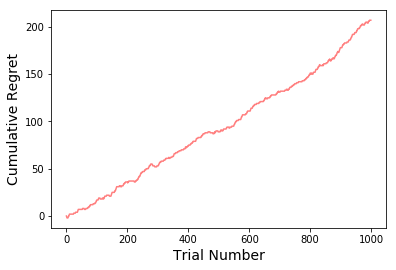

In [132]:
plot_cum_regret(all_rewards, optimal_rewards);

## Wrapper class to record metrics

In [135]:
class MetricsRecorder(gym.Wrapper):
    """Record metrics from an agent interacting with the wrapped environment."""

    def __init__(self, env):
        super().__init__(env)
        self.metrics = None
        self._current_step = 0
        self._compute_start = None
        self._last_observation = None

    def step(self, action):
        assert self._compute_start is not None, "Cannot call env.step() before calling reset()"
        time_for_decision = time.time() - self._compute_start
        observation, reward, done, info = self.env.step(action)

        # Record outcomes for this step
        t = self._current_step  # will be 0 on first call to step
        self.metrics.design_matrix[t] = self._last_observation.iloc[action]
        self.metrics.time_per_decision[t] = time_for_decision
        self.metrics.actions[t] = action
        self.metrics.optimal_actions[t] = info.get('optimal_action', np.nan)
        self.metrics.rewards[t] = reward
        self.metrics.optimal_rewards[t] = info.get('optimal_reward', np.nan)
        
        # Move to next step and restart timer
        self._current_step += 1
        if not done:
            self._last_observation = observation
            self._compute_start = time.time()  # reset compute timer
        else:
            self._compute_start = None

        return observation, reward, done, info

    def reset(self):
        self._last_observation = super().reset()
        self.metrics = SingleScenarioMetrics(
            self.env.initial_seed, self.env.num_time_steps, self.env.num_predictors)

        self._current_step = 0
        self._compute_start = time.time()
        return self._last_observation

In [136]:
cmab_env = gym.envs.make(env_name)
cmab_env = MetricsRecorder(cmab_env)
cmab_env

<MetricsRecorder<TimeLimit<ContextualBanditEnv<CMABRealsOnebestN10P10T100-v0>>>>

In [137]:
obs = cmab_env.reset()

while True:
    random_action = cmab_env.action_space.sample()
    obs, reward, done, info = cmab_env.step(random_action)
    if done:
        print(f"Episode finished after {t+1} timesteps")
        break

Episode finished after 1000 timesteps


In [138]:
results = cmab_env.metrics.as_df()
results.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p15,p16,p17,p18,p19,_action_,_optimal_action_,_reward_,_optimal_reward_,_compute_time_
time_step,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,0,...,0.0983863,0.0364307,0.749596,0.421807,0.526951,2,9,0.0,0.0,0.000175
1,0,0,0,0,0,1,0,0,0,0,...,0.620205,0.126462,0.34853,0.414075,0.0291249,5,9,0.0,0.0,0.000027
2,0,0,1,0,0,0,0,0,0,0,...,0.47958,0.200589,0.353206,0.374971,0.116897,2,9,1.0,0.0,0.000022
3,0,0,0,1,0,0,0,0,0,0,...,0.371647,0.0887754,0.643918,0.0467859,1.24034,3,9,0.0,0.0,0.000029
4,0,0,0,0,0,0,1,0,0,0,...,0.209773,0.551078,0.45536,0.792894,0.315695,6,9,0.0,0.0,0.000030


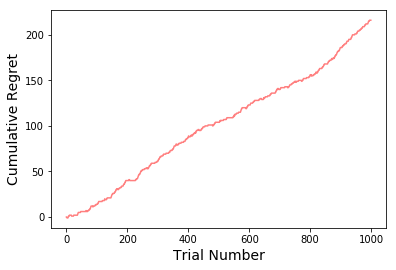

In [139]:
plot_cum_regret(results['_reward_'].values, results['_optimal_reward_'].values);

In [140]:
num_covariates = cmab_env.num_predictors
model = models.LogisticRegression(
    m0=np.zeros(num_covariates),
    P0=np.identity(num_covariates, dtype=np.float),
    num_samples=2)  # first sample discarded as burnin
model

In [142]:
SEED = 42
model.seed(SEED)
cmab_env.seed(SEED)

obs = cmab_env.reset()

all_actions = []
for t in range(1000):
    if t % 50 == 0:
        print(f'Step {t+1}')

    action = model.choose_arm(obs)
    all_actions.append(action)
    obs, reward, done, info = cmab_env.step(action)
    if done:
        print(f"Episode finished after {t+1} timesteps")
        break
    else:
        model.fit(cmab_env.metrics.design_matrix[:t],
                  cmab_env.metrics.rewards[:t])

Step 1
Step 51
Step 101
Step 151
Step 201
Step 251
Step 301
Step 351
Step 401
Step 451
Step 501
Step 551
Step 601
Step 651
Step 701
Step 751
Step 801
Step 851
Step 901
Step 951
Episode finished after 1000 timesteps


Regret: 48.0


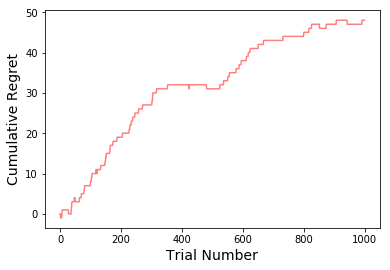

In [143]:
results = cmab_env.metrics.as_df()
regret = results['_optimal_reward_'].values - results['_reward_'].values
print(f'Regret: {np.sum(regret)}')
plot_cum_regret(results['_reward_'].values, results['_optimal_reward_'].values);

In [172]:
results[cmab_env.metrics.metadata_colnames].iloc[::50]

,_action_,_optimal_action_,_reward_,_optimal_reward_,_compute_time_
time_step,,,,,
0,3,9,0.0,0.0,0.010328
50,1,9,1.0,0.0,0.002009
100,5,9,0.0,1.0,0.002087
150,8,9,0.0,1.0,0.002215
200,9,9,0.0,0.0,0.002409
250,9,9,1.0,1.0,0.002787
300,9,9,0.0,0.0,0.003176
350,9,9,1.0,1.0,0.002349
400,9,9,1.0,1.0,0.003605


In [145]:
results._optimal_action_.astype(int).value_counts()

9    1000
Name: _optimal_action_, dtype: int64

In [146]:
results._action_.astype(int).value_counts()

9    802
5     31
1     29
6     22
2     22
8     21
4     21
7     20
3     16
0     16
Name: _action_, dtype: int64

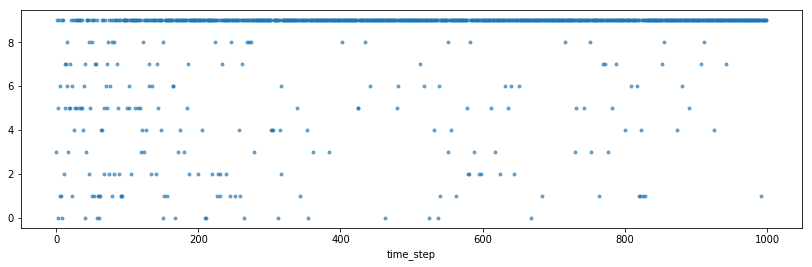

In [171]:
fig, ax = plt.subplots(figsize=(14, 4))
jitter = 0#np.random.normal(0, 0.03, size=len(results))
(results._action_ + jitter).plot(marker='o', markersize=3, linestyle='', alpha=0.6, ax=ax);

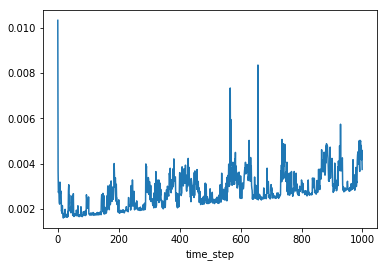

In [174]:
results._compute_time_.plot();